### Train Model Experiments NB 
notes:
added tensorboard to try and improve logging.  
random shear won't load
focus on most accurate approach which was adding softlayer with a higher learning rate
gradually tune the layers working backward with a final tuning of all layers
saving the best weights and reloading them was failing, since we have early stopping I just saved the full model each epoch
flipped model checkpoint back to saving the full model, this may fail again with efficientnet, needs to test at least once
min learning rate function not set to fall below 1e-5, changed to 1e-7
added regularization to dense layer to prevent overfitting with .001


In [1]:
# import the libraries for training, testing, validation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils  # will decode predictions out of the model into a 4 dim array of N (image num), imageID, label, probability result[0] would be the set of results for image one
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img  # will load img and reshape, usage is load_img(image_name_loc, target_size=input_shape)
from tensorflow.keras.utils import plot_model  # Note: usage syntax is plot_model(instantied_model, to_file='', show_shapes=True)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
# from tensorflow.keras.layers import RandomShear  # couldn't get random shear to load
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds  # For loading datasets from GCS
from tensorflow.keras.callbacks import ModelCheckpoint


# add capabilities to generate data and stop early as well as regulation options to avoid over fitting per experiment #1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# import all model architectures
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import InceptionV3


import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time
import math

# suppress warnings
from absl import logging  # tensorflow internal log
logging.set_verbosity(logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)


2025-04-13 15:08:26.913836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-13 15:08:29.362334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-04-13 15:08:29.362473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

In [2]:
# define a dictionary for model config and experiment tracking.... 
# define global variables
gcs_bucket = 'nabirds_filtered'  
dataset_path = 'images'  # Relative path within the bucket
default_batch_size = 32
default_image_size = (224, 224)

model_input_variables = {'MobileNetV2': {'input_shape': (224, 224, 3), 'batch_size': 32,},
     'MobileNetV3Large': {'input_shape': (224, 224, 3),'batch_size': 32,},
    'MobileNetV3Small':{'input_shape': (224, 224, 3), 'batch_size': 32,},
    'EfficientNetB0': {'input_shape': (224, 224, 3), 'batch_size': 32,},
    'InceptionV3': {'input_shape': (299, 299, 3), 'batch_size': 32,}, # InceptionV3 typically uses 299x299
    'EfficientNetB7':{'input_shape': (600, 600, 3), 'batch_size': 16,}, # this is a larger model and the norm seems to be smaller batch sizes for reduced memory use
    'EfficientNetB1': {'input_shape': (240, 240, 3), 'batch_size': 32,},  # added 1 thru 6 during experiment 3
    'EfficientNetB2': {'input_shape': (288, 288, 3), 'batch_size': 32,},
    'EfficientNetB3': {'input_shape': (300, 300, 3), 'batch_size': 32,},
    'EfficientNetB4': {'input_shape': (380, 380, 3), 'batch_size': 32,},
    'EfficientNetB5': {'input_shape': (456, 456, 3), 'batch_size': 32,},
    'EfficientNetB6': {'input_shape': (528, 528, 3), 'batch_size': 32,}
}
models_list = list(model_input_variables.keys())

In [3]:
def write_results_to_file(filename, experiment, start_time, end_time, model_name, epochs, 
                          training_accuracy, validate_accuracy, training_loss, validate_loss,
                          num_stages, stage1, stage2):
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    batch_size = str(model_input_variables[model_name]['batch_size'])
    input_shape = str(model_input_variables[model_name]['input_shape']).replace(',','x')
    stage1 = f"stage1 epochs:{stage1['epochs']} trainable: {stage1['base_trainable']} trainable layers: {stage1['trainable_layers']} learning rate: {stage1['learning_rate']}"
    stage2 = f"stage2 epochs:{stage2['epochs']} trainable: {stage2['base_trainable']} trainable layers: {stage2['trainable_layers']} learning rate: {stage2['learning_rate']}"
    line = f'{experiment},{start_time_str},{end_time_str},{model_name},{batch_size},{epochs},{input_shape},{training_accuracy},' \
           f'{validate_accuracy},{training_loss},{validate_loss},{num_stages},{stage1},{stage2}\n'
    if not os.path.exists(filename):      # Check if the file exists, and add a header if it's new
        header = 'experiment,start_time,end_time,model_name,batch_size,epochs,input_shape,training_accuracy,validate_accuracy,training_loss,validate_loss,num_stages,stage1,stage2\n'
        with open(filename, "w") as f:
            f.write(header + line)
    else:
        with open(filename, "a") as f: # append to existing file
            f.write(line)
    print(f'experiment tracking updated')
    return

In [4]:
def load_images_gcs(bucket_name, dataset_path, model_image_size, model_batch_size):
    dataset = None
    gcs_dataset_path = f"gs://{bucket_name}/{dataset_path}"
    try:
        dataset = keras.utils.image_dataset_from_directory(gcs_dataset_path, image_size=model_image_size,
            batch_size=model_batch_size, label_mode='categorical',)  # categorical is for softmax layer
    except Exception as e:
        print(f'error loading dataset from gcs: {e}')    
    return dataset

In [5]:
# split into its own cell so we do not have to repeat this long operation, takes 10 minutes....
# need to run this each time for different image and batch sizes
def load_images(image_size=default_image_size, batch_size=default_batch_size):
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start loading images time: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'Loading with image size of {image_size} and batch size of {batch_size}')

    train_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'train'), image_size, batch_size)
    validate_dataset = load_images_gcs(gcs_bucket, os.path.join(dataset_path, 'test'), image_size, batch_size)

    if train_dataset is None or validate_dataset is None:
        print(f'dataset loading failed.')
    return train_dataset, validate_dataset

In [6]:
def plot_training_results(acc, validate_acc, loss, validate_loss):
    epochs_plt = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_plt, acc, 'b', label='Training accuracy')
    plt.plot(epochs_plt, validate_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_plt, loss, 'b', label='Training loss')
    plt.plot(epochs_plt, validate_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [7]:
# lock and unlock layers, make this bullet proof so I don't have to think about the experiments too much
def lock_unlock_layers(model, train_last_x_layers):
    train_last_x_layers = 0 if train_last_x_layers == None else train_last_x_layers
    fine_tune_at = len(model.layers) - abs(train_last_x_layers)                        
    fine_tune_at = 0 if fine_tune_at < 0 else fine_tune_at
    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True
    return model

In [8]:
@tf.autograph.experimental.do_not_convert
def run_model_experiment(experiment_name, model_name, stages, stage1, stage2, train_dataset, validate_dataset, num_classes, log_record):
    stage1_learning = stage1["learning_rate"]
    stage1_epochs = stage1["epochs"]
    stage1_base_trainable = stage1['base_trainable']
    stage1_trainable_layers = stage1['trainable_layers']
    stage2_learning = stage2["learning_rate"]
    stage2_epochs = stage2["epochs"]
    stage2_base_trainable = stage2['base_trainable']
    stage2_trainable_layers = stage2['trainable_layers']
    
    start_time = time.time()
    start_time_datetime = datetime.datetime.fromtimestamp(start_time)
    print(f'Start time training and validation: {start_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'building model: {model_name} with {stages} stage(s)')
    print(f'stage1... ')
    print(f'epochs: {stage1_epochs}')
    print(f'learning rate of {stage1_learning}')
    print(f'trainable: {stage1_base_trainable}')
    print(f'trainable_layers: {stage1_trainable_layers}')
    
     # load each mode type and modify head for softmax replacement
    if model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(229, 229, 3))
    elif model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
    elif model_name == 'EfficientNetB1':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
    elif model_name == 'EfficientNetB2':
        base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(288, 288, 3))
    elif model_name == 'EfficientNetB3':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    else:
        print(f'unknown model {model_name} inf run_model_experiment case statement')

    ### setup call backs and other admin...
    # save best model, save model when monitored metric improved, 'max' for accuracy, 'min' for loss
    # callbacks early stopping and learning rate reduction
    # suppress warnings
    model_filename = experiment_name + model_name + '.h5'
    # model_checkpoint_callback = ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)  # added save weights for efficientnet
    # model_checkpoint_callback = ModelCheckpoint(filepath=model_filename, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001)
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    
    #####  setup stage 1 of X #####
    base_model.trainable = stage1_base_trainable  # true unlocks the entire model
    if stage1_base_trainable is False and stage1_trainable_layers != None:  # false a number unlocks the last x layers
        base_model = lock_unlock_layers(model=base_model, train_last_x_layers=stage1_trainable_layers)
    x = base_model.output  # start adding custom layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  
    predictions = Dense(num_classes, activation='softmax')(x)

    # create the model with rescaling layer, this will automatically normalize the images within the model, bulletproofs feeder code
    # normalize pixel values to [0, 1], not sure if this was done in the old mobilenetv2 model
    inputs = base_model.input
    rescaled_inputs = tf.keras.layers.Rescaling(1./255)(inputs)  
    augmentation_layers = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        # layers.RandomShear(0.2), # failed to load
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    ])
    augmented_inputs = augmentation_layers(rescaled_inputs) 
    x = base_model(augmented_inputs) 
    model = Model(inputs=inputs, outputs=predictions) # use original inputs
    
    # Define TensorBoard callback
    log_dir = os.path.join("logs", experiment_name + "_" + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
    # compile and train model, epoch zero is starting place for first stage, categorical crossentropy is for multi-class classification
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage1_learning), loss='categorical_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history_phase1 = model.fit(train_dataset, epochs=stage1_epochs, initial_epoch=0, validation_data=validate_dataset, 
                               callbacks=[early_stopping, reduce_lr] )  
                               # callbacks=[model_checkpoint_callback, early_stopping, reduce_lr] )  # removed model checkpoint as it was not working propertly

    ##### setup stage 2 if requested
    combined_history = {}
    print(f'history 1 keys: {history_phase1.history.keys()}')
    if stages == 2:
        print(f'stage2...')
        model = lock_unlock_layers(model=model, train_last_x_layers=stage2_trainable_layers)
        # Recompile the model and continue from phase1, last epoch + 1 to move to next available 
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=stage2_learning), loss='categorical_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        history_phase2 = model.fit(train_dataset, epochs=stage1_epochs + stage2_epochs, initial_epoch=stage1_epochs, validation_data=validate_dataset,
                                  callbacks=[early_stopping, reduce_lr])   
                                  # callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])   
        print(f'history2 keys: {history_phase2.history.keys()}')
        for key in history_phase1.history:  # combine history
            try:
                combined_history[key] = history_phase1.history[key] + history_phase2.history[key]
            except:
                pass
                #     print(f'history1 key {key} not found in history2 ')
        for key2 in history_phase2.history:
            if key2 not in history_phase1.history:
                combined_history[key2] = history_phase2.history[key2]
    else:
        stage2_epochs=0
        combined_history = history_phase1.history  # if one state take stage 1 hist    
                
    #### process results and save model
    # save the entire model (architecture + weights)
    try:
        model.save(model_filename)
        print(f'model saved to: {model_filename}')
    except Exception as e:
        print(f'model save failed with error {e}')
    
    # record training time
    end_time = time.time()
    end_time_datetime = datetime.datetime.fromtimestamp(end_time)
    print(f'End time training and validation: {end_time_datetime.strftime("%Y-%m-%d %H:%M:%S")}')

    # write_results_to_file
    total_epochs = stage1_epochs + stage2_epochs
    acc = combined_history['accuracy']
    validate_acc = combined_history['val_accuracy']
    loss = combined_history['loss']
    validate_loss = combined_history['val_loss']

    if log_record:
        write_results_to_file('experiment_log.csv', experiment_name, start_time_datetime, end_time_datetime, model_name, total_epochs, 
                              acc[-1], validate_acc[-1], loss[-1], validate_loss[-1], stages, stage1, stage2)
    plot_training_results(acc, validate_acc, loss, validate_loss) 
    return acc, validate_acc, loss, validate_loss

In [9]:
# the experiments dictionary drives the model types and training parameters 
# loop over each model type, stages, and write out results of experiment to a file, save the model
@tf.autograph.experimental.do_not_convert
def run_experiments(experiments, train_dataset, validate_dataset, num_classes, log_record=True):
    for exper in list(experiments.keys()):
        stages = experiments[exper]['number_of_stages']
        stage1 = experiments[exper]['stage1']
        stage2 = experiments[exper]['stage2']
        
        for model_num in experiments[exper]['model_types']:
            model_name = models_list[model_num]
            acc, validate_acc, loss, validate_loss = run_model_experiment(exper, model_name, stages, stage1, stage2, 
                                                                          train_dataset, validate_dataset, num_classes, 
                                                                         log_record)
    return

In [10]:
# load the default data 224x224x3 ,batch size 32 data set.  do not loop over this code unless its an exception. 
# takes about 10 minutes, note this will output warning/errors since this NB is not using a GPU
# request a different load for a different model size, copy and paste code and change parameters
default_train_dataset, default_validate_dataset = load_images()
num_classes = len(default_train_dataset.class_names) # get class count, same no mater how the data is loaded given the same data set

Start loading images time: 2025-04-13 15:08:32
Loading with image size of (224, 224) and batch size of 32
Found 2455 files belonging to 27 classes.
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f30289eb370> (key: FunctionCacheKey(function_type=FunctionType(parameters=[Parameter(name=args_kwargs, kindPOSITIONAL_ONLY, optional=False, type_constraint=Tuple(components=(Tuple(components=(TensorSpec(shape=(), dtype=tf.string, name=None),)), Dict(mapping={}))))], captures=OrderedDict()), call_context=FunctionContext(context=EagerContext(parent_graph=None, device_functions=(), colocation_stack=(), in_cross_replica_context=False, variable_policy=None, xla_context_id=0))))
Level 2:tensorflow:Python function signature [args: (TensorSpec(shape=(), dtype=tf.string, name=None),)] [kwargs: {}]
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrappe

2025-04-13 15:14:04.416354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-13 15:14:04.711810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-13 15:14:04.712122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-13 15:14:04.716623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Found 621 files belonging to 27 classes.
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f30289eb5b0> (key: FunctionCacheKey(function_type=FunctionType(parameters=[Parameter(name=args_kwargs, kindPOSITIONAL_ONLY, optional=False, type_constraint=Tuple(components=(Tuple(components=(TensorSpec(shape=(), dtype=tf.string, name=None),)), Dict(mapping={}))))], captures=OrderedDict()), call_context=FunctionContext(context=EagerContext(parent_graph=None, device_functions=(), colocation_stack=(), in_cross_replica_context=False, variable_policy=None, xla_context_id=0))))
Level 2:tensorflow:Python function signature [args: (TensorSpec(shape=(), dtype=tf.string, name=None),)] [kwargs: {}]
Level 1:tensorflow:Creating new FuncGraph for Python function <function StructuredFunctionWrapper.__init__.<locals>.trace_tf_function.<locals>.wrapped_fn at 0x7f30289eb880> (key: FunctionCacheKey(functio

### Experiments
quick primer:  
Accuracy: overall proportion of correct predictions (both true positives and true negatives) out of all predictions made.
Formula: (True Positives + True Negatives) / (Total Predictions)
Precision: measures the proportion of true positive predictions out of all positive predictions made by the model.
Formula: True Positives / (True Positives + False Positives)
Recall (also known as Sensitivity): measures the proportion of actual positive instances that the model correctly identified.
Formula: True Positives / (True Positives + False Negatives)

- Early experiment: learning_rate to low resulted in overfitting .001 with 50 epochs.  Added code to save best model since the results detoritated as more epochs were applied.  added libraries to generate more images if needed and for early stopping and learning rate reduction.  not in code yet 
- Experiment1: lowered learning rate to .0001 and trained for 25 epochs.  much better result.
- Experiment2: incorporated early stopping code and learning rate reduction and increased epochs to 50.  future: add regulaziation and drop out layers? add more training images?

In [11]:
### Available Models
print(f'Available models: {models_list}')
print(f'EfficientNetB0: {model_input_variables["EfficientNetB0"]}')
print(f'MobileNetV2: {model_input_variables["MobileNetV2"]}')
print(f'MobileNetV3Large: {model_input_variables["MobileNetV3Large"]}')
print(f'MobileNetV3Small: {model_input_variables["MobileNetV3Small"]}')
print(f'InceptionV3: {model_input_variables["InceptionV3"]}')
print(f'EfficientNetB7: {model_input_variables["EfficientNetB7"]}')
print(f'EfficientNetB1: {model_input_variables["EfficientNetB1"]}')
print(f'EfficientNetB2: {model_input_variables["EfficientNetB2"]}')

Available models: ['MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'EfficientNetB0', 'InceptionV3', 'EfficientNetB7', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6']
EfficientNetB0: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV2: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Large: {'input_shape': (224, 224, 3), 'batch_size': 32}
MobileNetV3Small: {'input_shape': (224, 224, 3), 'batch_size': 32}
InceptionV3: {'input_shape': (299, 299, 3), 'batch_size': 32}
EfficientNetB7: {'input_shape': (600, 600, 3), 'batch_size': 16}
EfficientNetB1: {'input_shape': (240, 240, 3), 'batch_size': 32}
EfficientNetB2: {'input_shape': (288, 288, 3), 'batch_size': 32}


### Chapter 4 Experiments
Focus on EfficientNetB0, MobilenetV3Large, MobileNetV2 (comparision), and possibly EfficientNetB1

In [13]:
#### Experiment 4 MobileNetV2 
# added 3 layers to model, train added layers in first stage, first stage platued at 4 epochs at 90.0% validation accuracy, 1e-3
# allow for deeper retaining in stage 2, 1e-4, do this by blocks, get the first block that is layer 222 to the end
# add stage 3 for full fine tuning ??
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment4: MobileNetV2: Chapter 4 Tuning': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0], # MobileNetv2
        'number_of_stages': 2, 
        'stage1': {'epochs': 5, 'base_trainable': False, 'trainable_layers': -3, 'learning_rate': 0.001},
        'stage2': {'epochs': 10, 'base_trainable': False, 'trainable_layers': -(238-222-1), 'learning_rate': 0.0001}
    }
}

# run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-04-13 15:16:12
building model: EfficientNetB0 with 2 stage(s)
stage1... 
epochs: 5
learning rate of 0.001
trainable: False
trainable_layers: -3
Epoch 1/5


2025-04-13 15:16:22.140694: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 47s 488ms/step - loss: 1.9557 - accuracy: 0.7336 - precision_1: 0.8702 - recall_1: 0.6338 - val_loss: 1.3684 - val_accuracy: 0.8390 - val_precision_1: 0.8807 - val_recall_1: 0.8084 - lr: 0.0010
Epoch 2/5
77/77 [==============================] - 39s 467ms/step - loss: 1.0456 - accuracy: 0.9246 - precision_1: 0.9516 - recall_1: 0.8965 - val_loss: 1.0427 - val_accuracy: 0.8776 - val_precision_1: 0.9161 - val_recall_1: 0.8615 - lr: 0.0010
Epoch 3/5
77/77 [==============================] - 39s 460ms/step - loss: 0.7211 - accuracy: 0.9593 - precision_1: 0.9670 - recall_1: 0.9422 - val_loss: 0.8548 - val_accuracy: 0.8776 - val_precision_1: 0.9092 - val_recall_1: 0.8551 - lr: 0.0010
Epoch 4/5
77/77 [==============================] - 38s 458ms/step - loss: 0.5392 - accuracy: 0.9650 - precision_1: 0.9733 - recall_1: 0.9519 - val_loss: 0.7453 - val_accuracy: 0.8824 - val_precision_1: 0.9111 - val_recall_1: 0.8744 - lr: 0.0010
Epoch 5/5
77/77 [=============

2025-04-13 15:19:45.110978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 47s 475ms/step - loss: 0.4032 - accuracy: 0.9711 - precision_2: 0.9852 - recall_2: 0.9499 - val_loss: 0.6023 - val_accuracy: 0.8921 - val_precision_2: 0.9074 - val_recall_2: 0.8841 - lr: 1.0000e-04
Epoch 7/15
77/77 [==============================] - 39s 462ms/step - loss: 0.3297 - accuracy: 0.9849 - precision_2: 0.9893 - recall_2: 0.9760 - val_loss: 0.5872 - val_accuracy: 0.8937 - val_precision_2: 0.9129 - val_recall_2: 0.8776 - lr: 1.0000e-04
Epoch 8/15
77/77 [==============================] - 38s 458ms/step - loss: 0.2915 - accuracy: 0.9943 - precision_2: 0.9955 - recall_2: 0.9910 - val_loss: 0.5587 - val_accuracy: 0.9018 - val_precision_2: 0.9174 - val_recall_2: 0.8937 - lr: 1.0000e-04
Epoch 9/15
77/77 [==============================] - 39s 466ms/step - loss: 0.2613 - accuracy: 0.9971 - precision_2: 0.9984 - recall_2: 0.9963 - val_loss: 0.5473 - val_accuracy: 0.8986 - val_precision_2: 0.9168 - val_recall_2: 0.8873 - lr: 1.0000e-04
Epoch 10/15

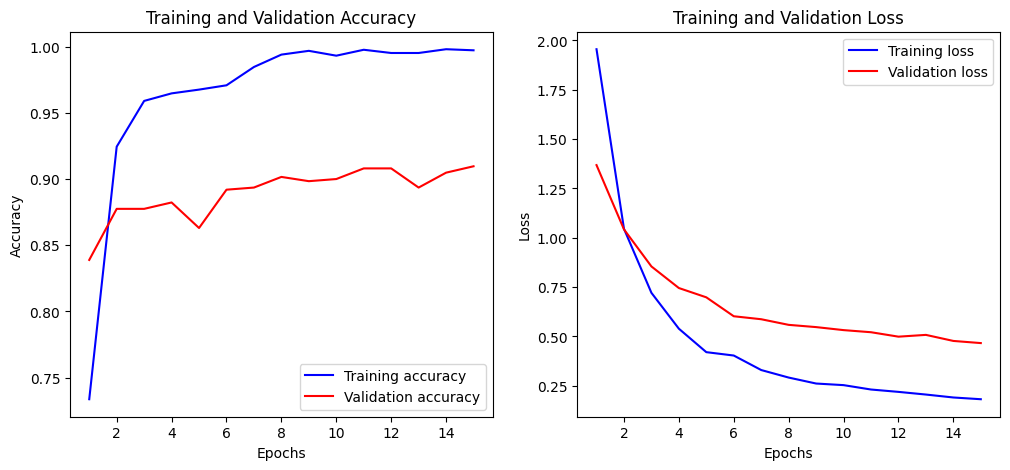

In [14]:
#### Experiment 4 EfficentNetB0 
# added 3 layers to model, train added layers in first stage, first stage platued at 4 epochs at 90.0% validation accuracy, 1e-3
# allow for deeper retaining in stage 2, 1e-4, do this by blocks, get the first block that is layer 222 to the end
# add stage 3 for full fine tuning ??
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment4: EfficientNetB0: Chapter 4 Tuning': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [3], # EfficientNetB0
        'number_of_stages': 2, 
        'stage1': {'epochs': 5, 'base_trainable': False, 'trainable_layers': -3, 'learning_rate': 0.001},
        'stage2': {'epochs': 10, 'base_trainable': False, 'trainable_layers': -(238-222-1), 'learning_rate': 0.0001}
    }
}

run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

In [ ]:
#### Experiment 4 MobileNetV3 Large
# added 3 layers to model, train added layers in first stage, first stage platued at 4 epochs at 90.0% validation accuracy, 1e-3
# allow for deeper retaining in stage 2, 1e-4, do this by blocks, get the first block that is layer 222 to the end
# add stage 3 for full fine tuning ??
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment4: MobileNetV3 Large: Chapter 4 Tuning': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [1], # MobilenetV3 Large
        'number_of_stages': 2, 
        'stage1': {'epochs': 5, 'base_trainable': False, 'trainable_layers': -3, 'learning_rate': 0.001},
        'stage2': {'epochs': 10, 'base_trainable': False, 'trainable_layers': -(238-222-1), 'learning_rate': 0.0001}
    }
}

# run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

In [ ]:
#### Experiment 4 EfficienetB1
# added 3 layers to model, train added layers in first stage, first stage platued at 4 epochs at 90.0% validation accuracy, 1e-3
# allow for deeper retaining in stage 2, 1e-4, do this by blocks, get the first block that is layer 222 to the end
# add stage 3 for full fine tuning ??
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment4:EfficientNetB1': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [6], # EfficientNetB1
        'number_of_stages': 2, 
        'stage1': {'epochs': 5, 'base_trainable': False, 'trainable_layers': -3, 'learning_rate': 0.001},
        'stage2': {'epochs': 10, 'base_trainable': False, 'trainable_layers': -(238-222-1), 'learning_rate': 0.0001}
    }
}

# run_experiments(experiment_dict, EfficientNetB1_train_dataset, EfficientNetB1_validate_dataset, num_classes)

### Final Experiments, #5 

Start time training and validation: 2025-04-13 18:20:53
building model: EfficientNetB0 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.001
trainable: True
trainable_layers: None
Epoch 1/50


2025-04-13 18:21:09.890070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 77s 568ms/step - loss: 2.3372 - accuracy: 0.6228 - precision_8: 0.8089 - recall_8: 0.5051 - val_loss: 2.4749 - val_accuracy: 0.6329 - val_precision_8: 0.7006 - val_recall_8: 0.5990 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 46s 559ms/step - loss: 1.2844 - accuracy: 0.8635 - precision_8: 0.9052 - recall_8: 0.8322 - val_loss: 2.0995 - val_accuracy: 0.6731 - val_precision_8: 0.7568 - val_recall_8: 0.6312 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 47s 560ms/step - loss: 0.9065 - accuracy: 0.9251 - precision_8: 0.9450 - recall_8: 0.8961 - val_loss: 1.4922 - val_accuracy: 0.7939 - val_precision_8: 0.8199 - val_recall_8: 0.7842 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 46s 554ms/step - loss: 0.6631 - accuracy: 0.9422 - precision_8: 0.9553 - recall_8: 0.9308 - val_loss: 1.3759 - val_accuracy: 0.7601 - val_precision_8: 0.8039 - val_recall_8: 0.7391 - lr: 0.0010
Epoch 5/50
77/77 [=========

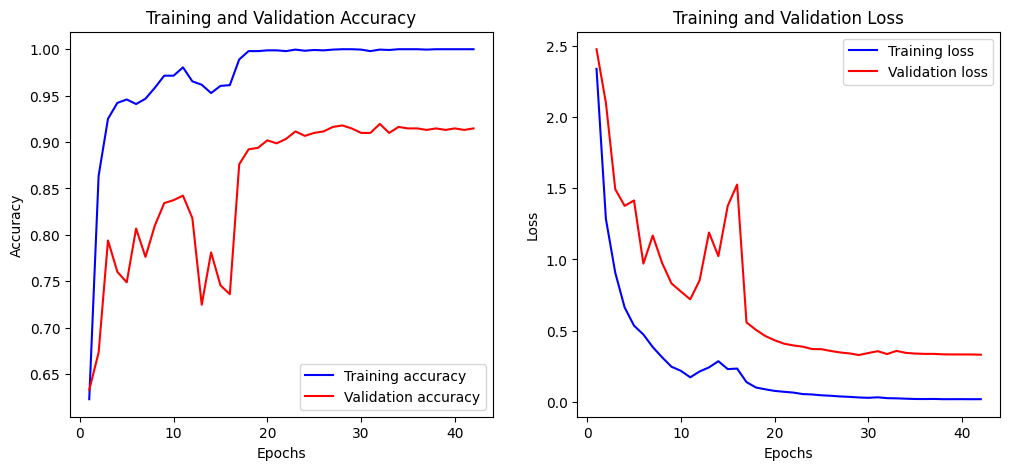

In [21]:
#### Experiment 5 EfficentNetB0 
# train all layers with data augmentation and regularization
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment5:EfficientNetB0': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [3], # EfficientNetB0
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.001},
        'stage2': {'epochs': 1, 'base_trainable': False, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-04-13 17:49:27
building model: MobileNetV3Large with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.0001
trainable: True
trainable_layers: None
Epoch 1/50
77/77 [==============================] - 77s 602ms/step - loss: 3.5285 - accuracy: 0.3259 - precision_7: 0.9381 - recall_7: 0.0432 - val_loss: 2.3031 - val_accuracy: 0.6361 - val_precision_7: 0.8723 - val_recall_7: 0.3301 - lr: 1.0000e-04
Epoch 2/50
77/77 [==============================] - 44s 518ms/step - loss: 1.6898 - accuracy: 0.8289 - precision_7: 0.9556 - recall_7: 0.6314 - val_loss: 1.7249 - val_accuracy: 0.7729 - val_precision_7: 0.8611 - val_recall_7: 0.6490 - lr: 1.0000e-04
Epoch 3/50
77/77 [==============================] - 40s 469ms/step - loss: 1.2399 - accuracy: 0.9446 - precision_7: 0.9795 - recall_7: 0.8974 - val_loss: 1.5532 - val_accuracy: 0.8100 - val_precision_7: 0.8724 - val_recall_7: 0.7375 - lr: 1.0000e-04
Epoch 4/50
77/77 [==============================] - 39s 459m

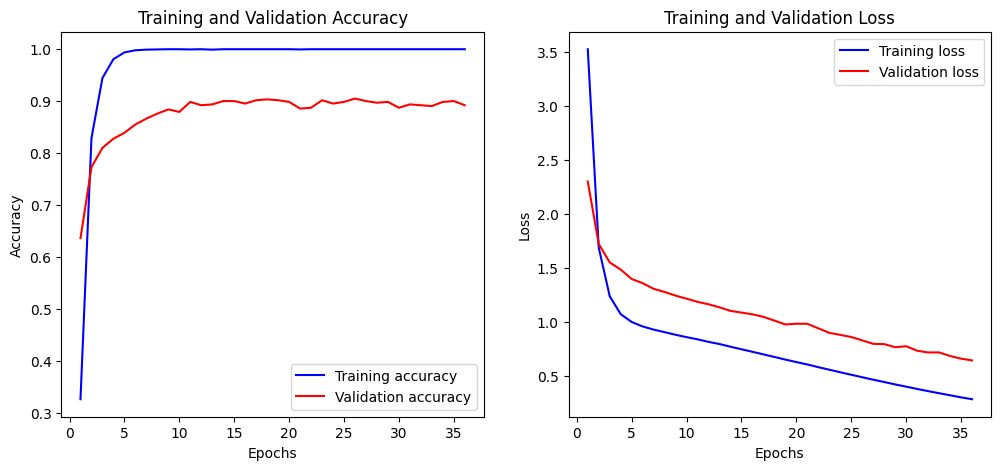

In [20]:
# #### Experiment 5 MobileNetV3 large 50 Epochs, transfer learning, all layers traininable, learing rate 0.0001
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment5:MobileNetV3Large': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [1], # mobilenetv3large
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.0001},
        'stage2': {'epochs': 1, 'base_trainable': False, 'trainable_layers': None, 'learning_rate': 0.0001}   
    }
}

run_experiments(experiment_dict, default_train_dataset, default_validate_dataset, num_classes)

Start time training and validation: 2025-04-13 17:07:14
building model: MobileNetV2 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.001
trainable: True
trainable_layers: None
Epoch 1/50
77/77 [==============================] - 87s 782ms/step - loss: 2.5912 - accuracy: 0.5487 - precision_6: 0.7349 - recall_6: 0.4257 - val_loss: 12.6496 - val_accuracy: 0.0853 - val_precision_6: 0.0890 - val_recall_6: 0.0837 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 53s 619ms/step - loss: 1.6263 - accuracy: 0.7507 - precision_6: 0.8321 - recall_6: 0.6823 - val_loss: 12.1251 - val_accuracy: 0.1401 - val_precision_6: 0.1395 - val_recall_6: 0.1320 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 43s 502ms/step - loss: 1.2239 - accuracy: 0.8318 - precision_6: 0.8697 - recall_6: 0.7914 - val_loss: 6.1429 - val_accuracy: 0.2383 - val_precision_6: 0.2725 - val_recall_6: 0.2142 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 39s 464ms/step - loss: 0

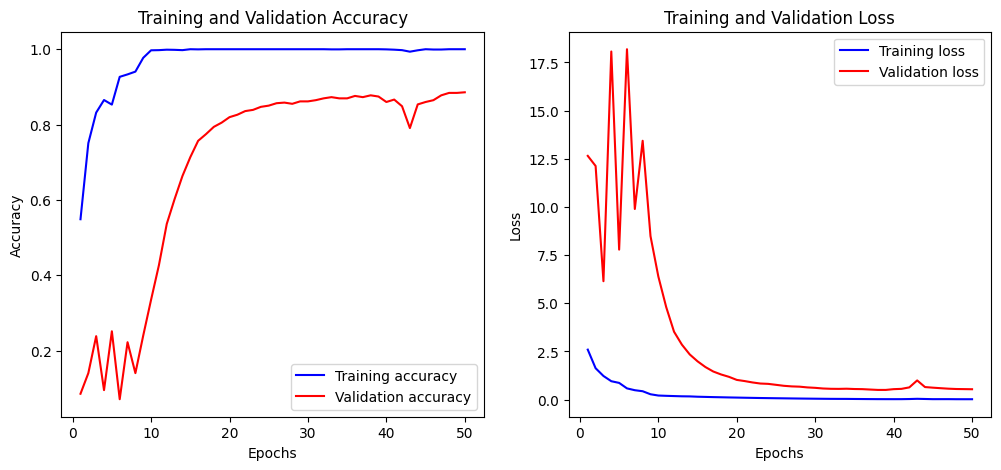

In [19]:
#### Experiment 5, MobileNetV2 Epochs
models_list = list(model_input_variables.keys())
experiments_dict = {
    'Experiment5:MobileNetV2': { 
        # 'model_types': [0, 1, 2, 3], # leave out the two models with weird image sizes for now
        'model_types': [0], # mobilenetv2 only
                'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.001},
        'stage2': {'epochs': 1, 'base_trainable': False, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

run_experiments(experiments_dict, default_train_dataset, default_validate_dataset, num_classes)

In [15]:
# load the data for EfficientNetB1
EfficientNetB1_train_dataset, EfficientNetB1_validate_dataset = load_images(image_size=(240, 240), batch_size=32)
num_classes = len(EfficientNetB1_train_dataset.class_names) # get class count, same no mater how the data is loaded given the same data set

Start loading images time: 2025-04-13 15:50:53
Loading with image size of (240, 240) and batch size of 32
Found 2455 files belonging to 27 classes.
Found 621 files belonging to 27 classes.


Start time training and validation: 2025-04-13 16:10:44
building model: EfficientNetB1 with 1 stage(s)
stage1... 
epochs: 50
learning rate of 0.001
trainable: True
trainable_layers: None
Epoch 1/50


2025-04-13 16:11:08.470108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 [==============================] - 116s 884ms/step - loss: 2.3786 - accuracy: 0.6183 - precision_5: 0.8079 - recall_5: 0.5055 - val_loss: 2.2161 - val_accuracy: 0.6393 - val_precision_5: 0.7575 - val_recall_5: 0.5684 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 68s 840ms/step - loss: 1.3994 - accuracy: 0.8391 - precision_5: 0.8955 - recall_5: 0.7890 - val_loss: 1.4624 - val_accuracy: 0.8084 - val_precision_5: 0.8654 - val_recall_5: 0.7762 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 69s 852ms/step - loss: 0.9492 - accuracy: 0.9075 - precision_5: 0.9325 - recall_5: 0.8835 - val_loss: 1.2682 - val_accuracy: 0.7858 - val_precision_5: 0.8416 - val_recall_5: 0.7617 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 69s 849ms/step - loss: 0.7187 - accuracy: 0.9369 - precision_5: 0.9505 - recall_5: 0.9230 - val_loss: 1.0772 - val_accuracy: 0.8229 - val_precision_5: 0.8591 - val_recall_5: 0.8052 - lr: 0.0010
Epoch 5/50
77/77 [========

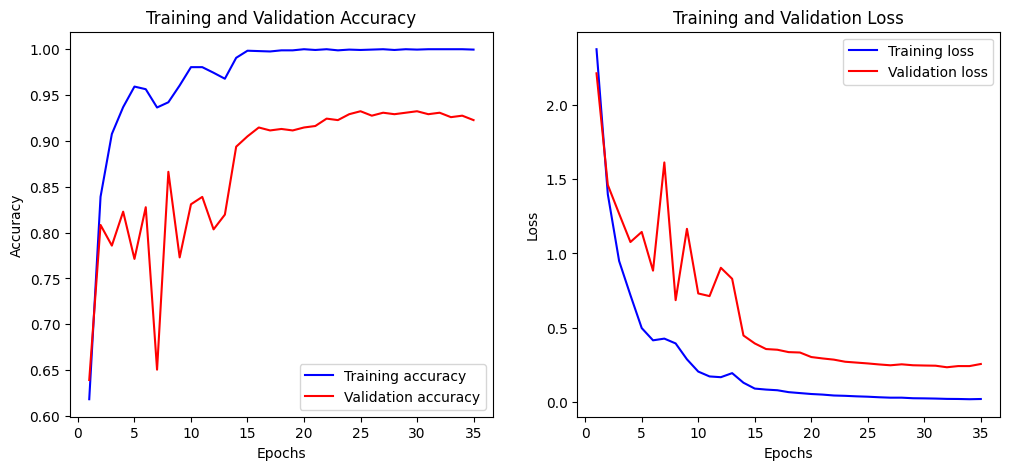

In [18]:
#### Experiment 5 EfficentNetB1 
# train all layers with data augmentation and regularization
models_list = list(model_input_variables.keys())
experiment_dict = {
    'Experiment5:EfficientNetB1': { 
        'model_types': [6], # EfficientNetB1
        'number_of_stages': 1, 
        'stage1': {'epochs': 50, 'base_trainable': True, 'trainable_layers': None, 'learning_rate': 0.001},
        'stage2': {'epochs': 1, 'base_trainable': False, 'trainable_layers': None, 'learning_rate': 0.00001}
    }
}

run_experiments(experiment_dict, EfficientNetB1_train_dataset, EfficientNetB1_validate_dataset, num_classes)